In [1]:
import os
import json
import numpy as np
from skimage import io, color
from myutils import *

In [3]:
images, labels = images_to_numpy_array('dataset')
print(images.shape)

(10360, 32, 32)


In [4]:
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

from myutils import *
from keras.preprocessing.image import ImageDataGenerator

/Users/ram/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
MODEL_SAVE_FOLDER = 'model'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Load images and labels
folder_path = "dataset"
images, eng_labels = images_to_numpy_array(folder_path)

# Normalize images and encode labels
images = images.astype("float32") / 255.0
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(eng_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a dictionary of labels and their inverse transformed values
label_dict = [label_encoder.inverse_transform([label])[0] for label in set(labels)]

# Write the dictionary to a file
with open('labels.list', 'w') as file:
    json.dump(label_dict, file)

In [8]:
# Define transformations for data augmentation (if needed)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

# Create custom datasets
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Initialize the model, loss function, and optimizer
model = create_net()
print(f'created network for labelling {len(set(labels))} classes')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
epoch_losses=[]
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


created network for labelling 70 classes
Epoch [1/200], Loss: 4.2486
Epoch [2/200], Loss: 4.2192
Epoch [3/200], Loss: 4.0931
Epoch [4/200], Loss: 3.8848
Epoch [5/200], Loss: 3.6791
Epoch [6/200], Loss: 3.4988
Epoch [7/200], Loss: 3.3382
Epoch [8/200], Loss: 3.1938
Epoch [9/200], Loss: 3.0624
Epoch [10/200], Loss: 2.9431
Epoch [11/200], Loss: 2.8316
Epoch [12/200], Loss: 2.7272
Epoch [13/200], Loss: 2.6284
Epoch [14/200], Loss: 2.5333
Epoch [15/200], Loss: 2.4433
Epoch [16/200], Loss: 2.3574
Epoch [17/200], Loss: 2.2747
Epoch [18/200], Loss: 2.1944
Epoch [19/200], Loss: 2.1183
Epoch [20/200], Loss: 2.0459
Epoch [21/200], Loss: 1.9763
Epoch [22/200], Loss: 1.9095
Epoch [23/200], Loss: 1.8463
Epoch [24/200], Loss: 1.7854
Epoch [25/200], Loss: 1.7252
Epoch [26/200], Loss: 1.6702
Epoch [27/200], Loss: 1.6185
Epoch [28/200], Loss: 1.5662
Epoch [29/200], Loss: 1.5183
Epoch [30/200], Loss: 1.4708
Epoch [31/200], Loss: 1.4244
Epoch [32/200], Loss: 1.3821
Epoch [33/200], Loss: 1.3386
Epoch [34/2

In [10]:
epoch_losses = np.array(epoch_losses)
epoch_losses

array([4.24855968, 4.21922716, 4.09309059, 3.88478023, 3.67912126,
       3.49878048, 3.33815593, 3.19382945, 3.06243695, 2.94311771,
       2.83158732, 2.72718401, 2.62838176, 2.53328992, 2.44330641,
       2.35735775, 2.27470797, 2.19442727, 2.11830125, 2.04586764,
       1.97625222, 1.90947193, 1.84632693, 1.7853629 , 1.72523213,
       1.67016609, 1.61846477, 1.56617307, 1.51832314, 1.47078009,
       1.42440854, 1.38208905, 1.33859196, 1.30034417, 1.26078279,
       1.22596669, 1.18891832, 1.1556301 , 1.12134769, 1.09168883,
       1.0608565 , 1.03233099, 1.00354475, 0.97731116, 0.95020152,
       0.9253354 , 0.90287255, 0.87892646, 0.85556775, 0.83541547,
       0.81402003, 0.79382716, 0.77479165, 0.75586131, 0.73751171,
       0.71995401, 0.70329465, 0.68702805, 0.67188881, 0.65633308,
       0.64188807, 0.62727459, 0.61387068, 0.6005236 , 0.58788601,
       0.57487545, 0.56294356, 0.55067419, 0.53954899, 0.52853244,
       0.51810007, 0.50764382, 0.49752284, 0.48818534, 0.47794

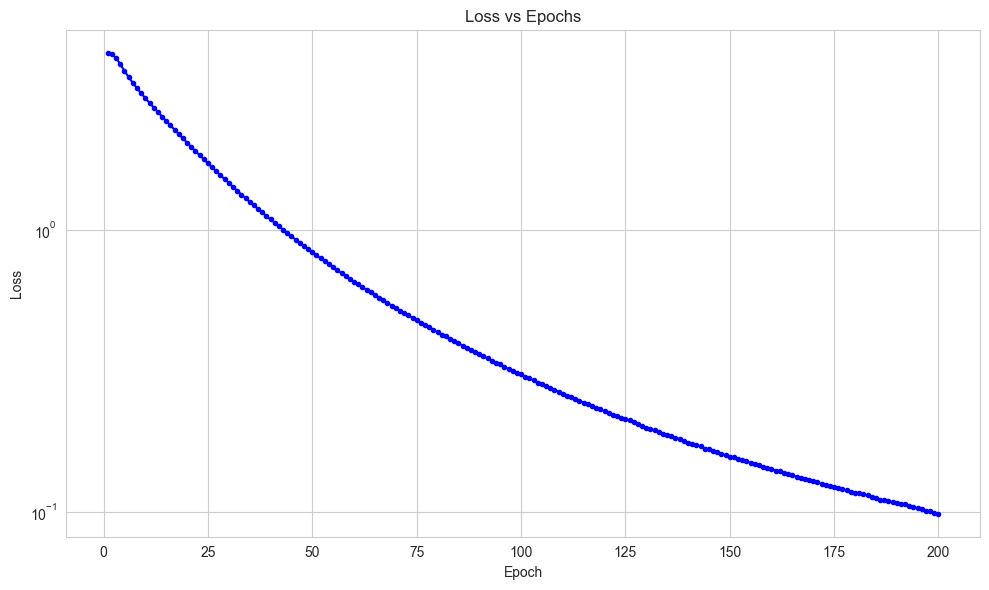

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example epoch loss data (replace this with your actual 

# Set the style for the plot
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='.', color='b', linestyle='-')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xticks(range(1, len(epoch_losses) + 1))
# plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.yscale('log')
# plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        print(outputs.shape)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"\nAccuracy on test set: {accuracy:.4f}")

torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([3

In [13]:
import datetime
# Save the model to a file
# Save the model to a file with a timestamp-based name
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
if not os.path.exists(MODEL_SAVE_FOLDER):
    os.makedirs(MODEL_SAVE_FOLDER)
filename = MODEL_SAVE_FOLDER+'/'+f"model_{timestamp}.pth"
torch.save(model.state_dict(), filename)